<a href="https://colab.research.google.com/github/EugenHotaj/nn-hallucinations/blob/master/NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer - Notebook for Colab

This notebook can be run on Google Colab to accelerate training with GPU. You can import your own images to try neural style transfer with them. Make sure the file paths are correct so that the code runs smoothly.

After a few setup cells, I go through 2 different NST methods in separate sections, for quite close results (differences explained below - let's jump in!).

In [0]:
%reset -f

In [4]:
!pip install kornia
!rm -rf nst
!git clone https://github.com/tdemareuil/Neural_Style_Transfer_Flask nst

     |████████████████████████████████| 143kB 7.6MB/s 
Cloning into 'nst'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 157 (delta 63), reused 66 (delta 23), pack-reused 0
Receiving objects: 100% (157/157), 25.70 MiB | 21.86 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [0]:
import collections
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms, models
import copy
import kornia
from nst import colab_utils
# from google.colab import files # if nst not cloned
from torch import nn
from torch.nn import functional as F
from skimage import io

In [6]:
print(colab_utils.get_device())

cuda


In [ ]:
colab_utils.upload_files()
# files.upload()
!ls /tmp # the colab_utils function loads the file in Colab's /tmp folder

# Method 1: my method

### Tool functions

In [0]:
def load_image(img_path, max_size=400, shape=None):
    '''
    Load in and transform user images. The function (1) resizes large images so 
    that they don't slow down processing, (2) normalizes image using ImageNet mean
    and stddev (as VGG19 was trained on ImageNet), and (3) converts to tensor.
    '''
    
    image = Image.open(img_path).convert('RGB')
    
    # define size
    if max(image.size) > max_size: # max_size along both x and y axes, default is 400
        size = max_size
    else:
        size = max(image.size)
    if shape is not None: # possible to choose a shape as size argument
        size = shape   
    
    # apply transformations
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), # ImageNet mean
                                             (0.229, 0.224, 0.225))]) # ImageNet stddev
    # remark: we could also choose to apply normalization as a first layer in the model

    # discard the transparent alpha channel with [:3] and add the batch dimension with unsqueeze()
    image = in_transform(image)[:3,:,:].unsqueeze(0) # unsqueeze(0) adds a 1-dimension at shape position 0
    
    return image
  

  def im_convert(tensor):
    '''
    Unnormalize and convert a tensor image to numpy to be able to display it.
    Remark: you need to use plt.imshow(image) after the function for display.
    '''
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze() # squeeze removes axes of size 1 (singletons)
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

### Modeling functions

We use the pre-trained VGG19 model - for reasons still unclear, other architectures yield less satisfying results (see [link](https://www.reddit.com/r/MachineLearning/comments/7rrrk3/d_eat_your_vggtables_or_why_does_neural_style/).

In [0]:
def get_vgg19():
    # get the "features" portion of VGG19 (we don't need the "classifier" portion)
    vgg = models.vgg19(pretrained=True).features

    # freeze all VGG parameters since we're only optimizing the target image
    for param in vgg.parameters():
        param.requires_grad_(False)
 
    return vgg

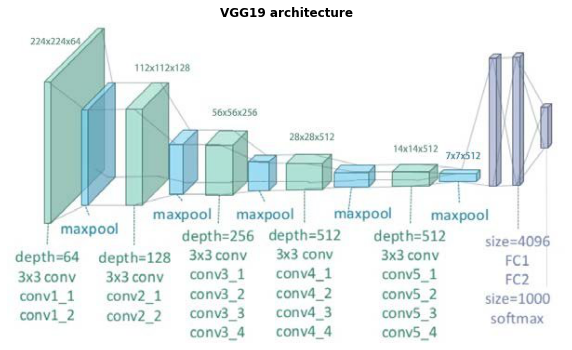

In [24]:
image = io.imread('https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg')
plt.figure(figsize=(10,6))
plt.imshow(image)
plt.title('VGG19 architecture', fontweight='semibold')
plt.axis('off');

We set functions to get the feature representation of our image in the layers defined by _Gatys et al._, and to compute the gram matrices (style representations, computed as correlation beween feature mappings).

In [0]:
def get_features(image, model, layers=None):
    '''
    Run an image forward through the model and get the features as a dictionary for a set of layers.
    Default layers are VGG19 layers, matching Gatys et al.'s paper (2016)
    '''
   
    if layers is None:
        # conv4_2 is the content representation layer, the others will be used as style layers
        layers = {'0': 'conv1_1', 
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1', 
                  '21': 'conv4_2', 
                  '28': 'conv5_1'}
   
    features = {}
    input_image = image
    
    for name, layer in model._modules.items(): # model._modules is a dictionary holding each module in the model
        layer_output = layer(input_image)
        if name in layers:
            features[layers[name]] = layer_output
            
    return features


def gram_matrix(tensor):
    
    batch_size, channels, height, width = tensor.size() # tensor.shape works as well
    
    # multiplying the features for each channel to create a reshaped tensor
    tensor = tensor.view(channels, height * width) # batch_size is 1 (due to unsqueeze)
    
    # compute the gram matrix
    gram = torch.mm(tensor, tensor.t()) # dot product between feature mappings in a layer
    
    # we could also normalize it here with gram.div(channels*height*width) - we do it in `stylize` below
    return gram

We define the function that runs the model and applies style transfer:

In [0]:
def stylize(content, style, model, steps):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu (cuda) if possible
    
    # load in content, style and model
    content = content.to(device)
    style = style.to(device)
    vgg = model.to(device)
    
    # get content and style features for the 2 input images (content and style)
    content_features = get_features(content, vgg)
    style_features = get_features(style, vgg)

    # calculate the gram matrices for each layer of our style representation (style_features)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    # create a third "target" image (copy of the content image) and iteratively change its style
    target = content.clone().requires_grad_(True).to(device)
    
    # iteration hyperparameters
    style_weights = {'conv1_1': 0.6,
                     'conv2_1': 0.5,
                     'conv3_1': 0.5,
                     'conv4_1': 0.8,
                     'conv5_1': 0.8}
    content_weight = 1  # alpha (for total loss computation)
    style_weight = 1e5  # beta (for total loss computation)
    optimizer = optim.Adam([target], lr=0.05) # we use ADAM, vs LBFGS in Gatys et al.
    steps = steps  # decide how many iterations to update your image

    # iterate over the nb of steps
    for i in range(1, steps+1):

        # get the features of the target image for computation of losses at this step
        target_features = get_features(target, vgg)

        # CONTENT LOSS:
        # we use MSE and 'conv4_2' features as a representation of content, following Gatys et al.
        # see other method (L1 loss and `conv3_2`) in the next section
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

        # STYLE LOSS: initialize the style loss to 0 and iterate through each style layer to increment it
        style_loss = 0
        for layer in style_weights:
            # get the features and gram matrix of the target image in the given layer
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)

            # get the gram matrix of the style image
            style_gram = style_grams[layer]

            # compute style loss for the layer, weighted appropriately
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            
            # normalize and add to total style loss
            _, d, h, w = target_feature.shape
            style_loss += layer_style_loss / (d * h * w)

        # TOTAL LOSS:
        total_loss = content_weight * content_loss + style_weight * style_loss

        # update the target image to end iteration
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    return target

### Run model

Wrapping it all:

In [0]:
colab_utils.get_device()

device(type='cuda')

In [0]:
content = load_image('/content/nst/static/images/inputs/input2.jpg', max_size=400) # choose image size
style = load_image('/content/nst/static/images/styles/s5.jpg', shape=content.shape[-2:]) # resize style to match content

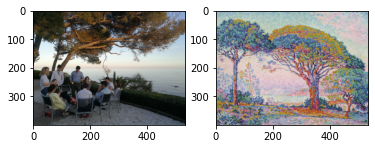

In [0]:
x = im_convert(content)
y = im_convert(style)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(y);
ax2.imshow(z);

In [0]:
vgg = get_vgg19()

In [0]:
%%time
target = stylize(content, style, vgg, steps=3000)

CPU times: user 1min 14s, sys: 54.9 s, total: 2min 9s
Wall time: 2min 9s


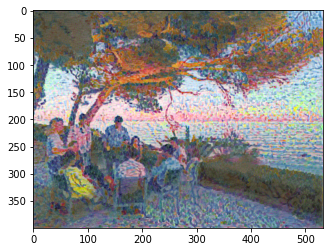

In [0]:
z = im_convert(target)
plt.imshow(z);

In [0]:
plt.imsave('/content/output.png', z)

If the result isn't satisfying enough, try first to adjust the number of steps, and then potentially other parameters ! E.g.: different weights for `content_loss`and `style_loss` in the total loss (depending on what you want to see stand out more), smaller learning rate, replacing `conv4_2` with `conv3_2` (see method 2 below), smaller image size, etc., and also try the other method below - neural style transfer is a vast playground!

# Method 2: Eugen Hotaj, [link](https://towardsdatascience.com/how-to-get-beautiful-results-with-neural-style-transfer-75d0c05d6489)

The code below is an attempt to improve output quality by tweaking certain elements. The main differences with the previous method and with the original _Gatys et al._ paper are:

* use `conv3_2` instead of `conv4_2` as the layer for content feature mapping, i.e. a layer less deep in the network in order to get results more faithful to the original content
* apply some augmentations to the input image (e.g rotation, cropping, resizing, etc., with the `kornia` library) before running it through the model and computing the loss, in order to force the model to generate features which are more robust to minor perturbations - they should contain less high frequency artifacts and generally look more visually appealing
* replace VGG19's `MaxPool2d` layers with `AvgPool2d`, as it is done in the original paper
* switch the `mse_loss` (i.e. `l2_loss`) to `l1_loss`, as the square term heavily penalizes outliers, while we can actually tolerate a few outliers in the generated image - they might even lead to more visually pleasing results 
* compute losses each time on the output of the `relu` layers instead of the `conv` layers (no real improvement in quality, but might accelerate computation a little)
* use a randomly created image as the image to modify iteratively, instead of a copy of the content image (again, this one might not really change the result).

The model itself is built a little differently in this method, with functions organized under classes and inserted in the model as pytorch modules.

This model doesn't give significantly better results on the images I tested, but it does run faster than mine - I could probably use some of its ideas to improve my model.

### Import content and style images

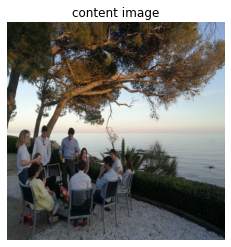

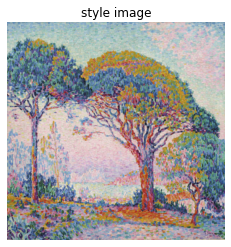

In [0]:
imsize = 512 if torch.cuda.is_available() else 128  # use a small size on CPU

content_img = colab_utils.load_image("/content/nst/static/images/inputs/input2.jpg", size=imsize)
content_img = content_img.unsqueeze(0).to(colab_utils.get_device())
style_img = colab_utils.load_image("/content/nst/static/images/styles/s5.jpg", size=imsize)
style_img = style_img.unsqueeze(0).to(colab_utils.get_device())

colab_utils.imshow(content_img, title="content image")
colab_utils.imshow(style_img, title="style image")

### Create modules for normalization and losses

In [0]:
class ImageNetNormalize(nn.Module):
  """Module which normalizes inputs using the ImageNet mean and stddev."""

  def __init__(self):
    super().__init__()
    self._transform = transforms.Normalize(
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

  def forward(self, input):
    # Remove the batch dimension before transforming then add it back.
    # Warning: This only produces sane results when batch_size=1.
    return self._transform(input.squeeze(0)).unsqueeze(0)

In [0]:
class ContentLoss(nn.Module):
  """The content loss module.
  Computes the L1 loss between the target and the input.
  """

  def __init__(self, target):
    """Initializes a new ContentLoss instance.
    
    Args:
      target: Take the L1 loss with respect to this target.
    """
    super().__init__()
    # We detach the target from the computation graph since we want to use the
    # actual value.
    self._target = target.detach()
    self.loss = None

  def forward(self, input):
    self.loss = F.l1_loss(input, self._target)
    return input

In [0]:
class StyleLoss(nn.Module):
  """The style loss module.
  
  Computes the L1 loss between the gram matricies of the target feature and the
  input.
  """

  def __init__(self, target_feature):
    """Initializes a new StyleLoss instance.
    
    Args:
      target_feature: Take the L1 loss with respect to this target feature.
    """
    super().__init__()
    # We detach the target_feature and target from the computation graph since
    # we want to use the actual values.
    self._target = self._gram_matrix(target_feature.detach()).detach()
    self.loss = None

  def _gram_matrix(self, input):
    """Returns the normalized Gram matrix of the input."""
    n, c, w, h = input.size()
    features = input.view(n * c, w * h)
    G = torch.mm(features, features.t())
    return G.div(n * c * w * h)

  def forward(self, input):
    G = self._gram_matrix(input)
    self.loss = F.l1_loss(G, self._target)
    return input

### Create model

In [0]:
def get_nst_model_and_losses(model,  content_img,  style_img, content_layers, style_layers):
  """Creates the Neural Style Transfer model and losses. 

  Args:
    model: The model to use for Neural Style Transfer. ContentLoss and StyleLoss
      modules will be inserted after each layer in content_layers and 
      style_layers respectively.

    content_img: The content image to use when creating the ContentLosses.

    style_img: The style image to use when creating the StyleLosses.

    content_layers: The name of the layers after which a ContentLoss module will
      be inserted.

    style_layers: The name of the layers after which a StyleLoss module will be
      inserted.

  Returns: A three item tuple of the NST model with ContentLoss and StyleLoss 
    modules inserted, the ContentLosses modules, and the StyleLosses modules.
  """

  nst_model = nn.Sequential(ImageNetNormalize())

  content_losses, style_losses, last_layer = [], [], 0
  for i, (name, layer) in enumerate(copy.deepcopy(model).named_children()):
    nst_model.add_module(name, layer)
    if name in content_layers:
      content_loss = ContentLoss(nst_model(content_img))
      nst_model.add_module(f'{name}_ContentLoss', content_loss)
      content_losses.append(content_loss)
      last_layer = i
    if name in style_layers:
      style_loss = StyleLoss(nst_model(style_img))
      nst_model.add_module(f'{name}_StyleLoss', style_loss)
      style_losses.append(style_loss)
      last_layer = i

  # Sanity check that we have the desired number of style and content layers.
  assert len(content_losses) == len(content_layers), 'Not all content layers found.'
  assert len(style_losses) == len(style_layers), 'Not all style layers found.'

  # Remove the layers after the last StyleLoss and ContentLoss since they will
  # not be used for style transfer. To get the correct last_layer index, we 
  # take into account the ImageNetNormalization layer at the front and the
  # ContentLoss and StyleLoss layers.
  last_layer += 1 + len(content_losses) + len(style_losses)
  nst_model = nst_model[:last_layer+1].to(colab_utils.get_device())
  
  return nst_model, content_losses, style_losses 

In [0]:
def modify_vgg_layers(model):
  """Replaces VGG19's ReLU and Pooling layers and renames them."""

  block, number = 1, 1
  renamed = nn.Sequential()
  
  for layer in model.children():
    if isinstance(layer, nn.Conv2d):
      name = f'conv{block}_{number}'
    elif isinstance(layer, nn.ReLU):
      name = f'relu{block}_{number}'
      # The inplace ReLU version doesn't play nicely with NST.
      layer = nn.ReLU(inplace=False)
      number += 1
    elif isinstance(layer, nn.MaxPool2d):
      name = f'pool_{block}'
      # Average pooling was found to generate images of higher quality than
      # max pooling by Gatys et al.
      layer = nn.AvgPool2d(layer.kernel_size, layer.stride)
      block += 1
      number = 1
    else:
      raise RuntimeError(f'Unrecognized layer "{layer.__class__.__name__}""')

    renamed.add_module(name, layer)
  return renamed.to(colab_utils.get_device())

In [0]:
model = models.vgg19(pretrained=True).features.to(colab_utils.get_device()).eval()
model = modify_vgg_layers(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


### Run model

In [0]:
def run_style_transfer(
    model, 
    content_img, 
    style_img, 
    content_layers,
    style_layers,
    input_img=None, 
    num_steps=512, 
    content_weight=1., 
    style_weight=1e9,
    log_steps=50):
  """Runs Neural Style Transfer.
  
  Args:
    model: The Neural Style Transfer model to use.
    content_image: The image whose content to match during the optimization. 
    style_image: The image whose style to match during the optimization.
    content_layers: The names of the layers whose output will be used to compute
      the content losses.
    style_layers: The names of the layers whose output will be used to compute
      the style losses.
    input_img: The image which will be optimized to match the content and style
      of the content_img and style_img respectively. If None, defaults to random
      Gaussian noise.
    num_steps: The number of steps to run the optimization for.
    content_weight: A weight to multiply the content loss by. 
    style_weight: A weight to multiply the style loss by. 
    log_steps: The number of consecutive training steps to run before logging.
  Returns:
    The optimized input_img.
  """

  n, c, h, w = content_img.data.size()

  if input_img is None:
    input_img = torch.randn((n, c, h, w), device=colab_utils.get_device())
    input_img = input_img * .01  # Scale the noise variance down.
  
  model, content_losses, style_losses = get_nst_model_and_losses(
      model, content_img, style_img, content_layers, style_layers)
  optimizer = optim.Adam([input_img.requires_grad_()], lr=.05)

  # NOTE(eugenhotaj): Making the generated image robust to minor transformations
  # was shown in https://distill.pub/2017/feature-visualization to produce more
  # visually appealing results. We observe the same thing but note that our
  # transformations are a lot more mild as aggresive transformations produce 
  # rotation and scaling artifacts in the generated image.
  transform = nn.Sequential(
      kornia.augmentation.RandomResizedCrop(
          size=(w, h), scale=(.97, 1.), ratio=(.97, 1.03)),
      kornia.augmentation.RandomRotation(degrees=1.))
  
  for step in range(num_steps):
    optimizer.zero_grad()
    input_img.data.clamp_(0, 1)
    model(transform(input_img))
    content_loss, style_loss = 0, 0
    for cl in content_losses:
      content_loss += content_weight * cl.loss
    for sl in style_losses:
      style_loss += style_weight * sl.loss
    loss = content_loss + style_loss 
    loss.backward()
    optimizer.step()
    
    if (step > 0 and step % log_steps == 0) or (step + 1) == num_steps:
      print(f'[{step}]: content_loss={content_loss.item()},'
            f' style_loss={style_loss.item():4f}')
      colab_utils.imshow(input_img.data.clamp_(0, 1), figsize=(10, 10))
  
  return input_img

[250]: content_loss=0.6632992625236511, style_loss=0.415891
[500]: content_loss=0.733738124370575, style_loss=0.569789
[750]: content_loss=0.6650040149688721, style_loss=0.296820
[1000]: content_loss=0.7018342614173889, style_loss=0.416861
[1023]: content_loss=0.6241369247436523, style_loss=0.300519


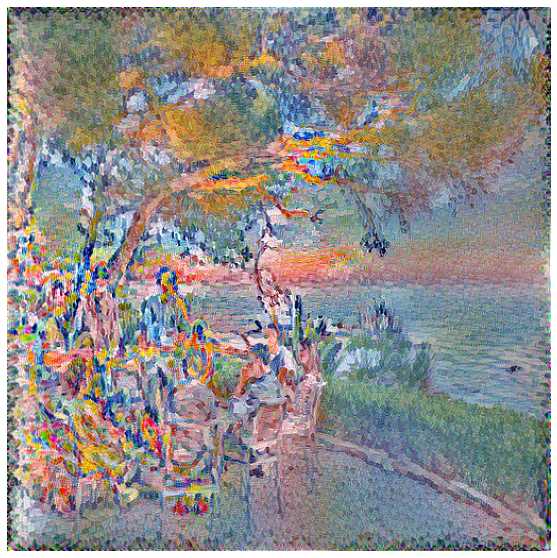

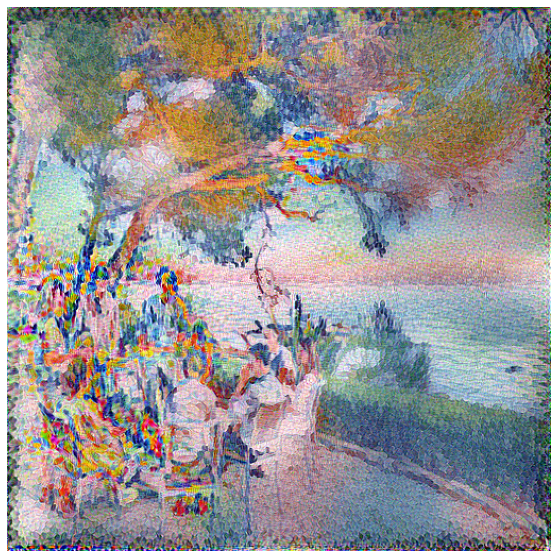

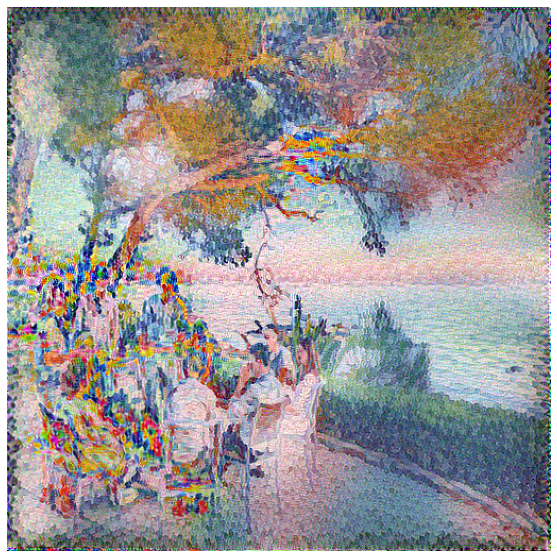

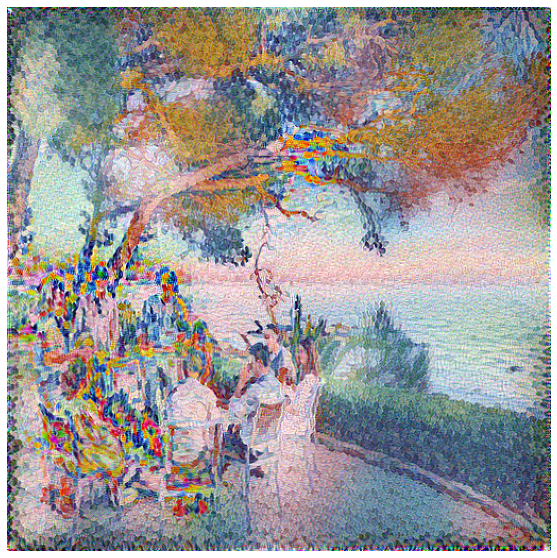

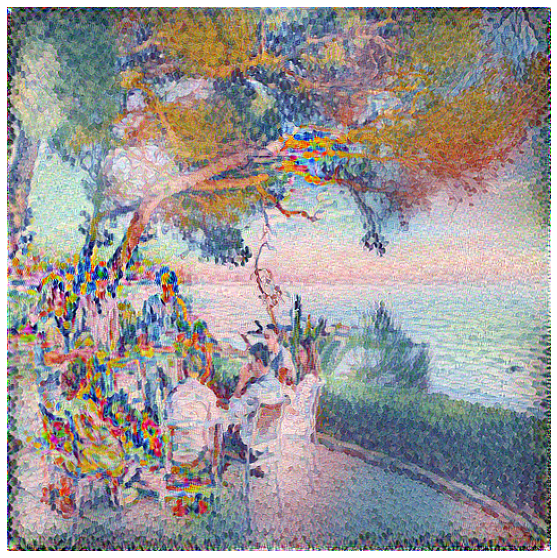

In [0]:
# NOTE: It's unclear from Gatys et al. whether to use the outputs of
# the conv layer or the (ReLU) activations. We use the latter here as ad-hoc
# experiments did not show a difference in quality, although the loss seems to
# be a lot higher when using the conv layer outputs.
vgg_default_content_layers = ['relu4_2']
vgg_default_style_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']

# Uncomment one of the lines below to use as the input_img to optimize.
input_img = None
# input_img = content_img.clone()
# input_img = style_img.clone()

output = run_style_transfer(
    model=model, 
    content_img=content_img, 
    style_img=style_img,
    # Note: Gatys et al. use conv4_2 as the content layer. However,
    # we found that relu3_2 produces more visually appealing results.
    content_layers=['relu3_2'],
    style_layers=vgg_default_style_layers,
    num_steps=1024,
    content_weight=1.,
    style_weight=1000.,
    log_steps=250)

$\rightarrow$ Problems with this method:  
* resizes the content and style image to square format
* creates artifacts around the output image due to image augmentation
* creates noisy output on some parts of the image.

# Other improvements

This other [blog post](https://medium.com/@shwetaka1988/a-complete-step-wise-guide-on-neural-style-transfer-9f60b22b4f75) proposes another improvement: to avoid noisy and overly pixelated results, add "variation loss" next to style and content losses.

As minimizing only the style and content losses can lead to noisy outputs, variation loss helps ensure spatial continuity and smoothness in the generated image by computing and minimizing the difference between neighbouring pixels.

Code is below (using `tensorflow`):

>`def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]
  return x_var, y_var
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)`
  
And the proposed weights for total loss computation are:
>`style_weight=1e-2
content_weight=1e4
total_variation_weight=1e8`

Proving that there is still a lot to explore in the field of neural style transfer and artistic deep learning!